In [1]:
# load the packages needed
import numpy as np

import sys
if "../" not in sys.path:
    sys.path.append("../")
from tsap.solver import Solver
from tsap.model import AR, MA
from tsap.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array

import tsap.data_processor as dp
import tsap.inference as inference
from tsap.ts_gen import ar1_gen

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

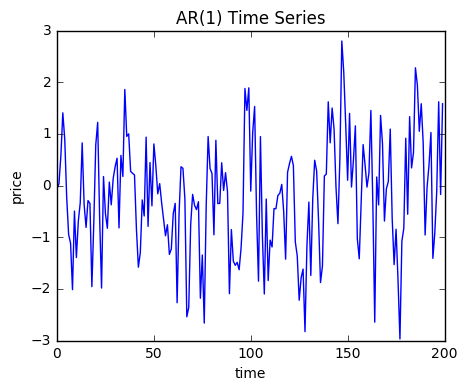

In [2]:
# generate a fake time series and plot it
from tsap.ts_gen import ar1_gen
Y = ar1_gen(0.5, sigma = 1.0, time = 200, num = 1, burnin = 2000)
plt.plot(Y.T)
plt.xlabel('time')
plt.ylabel('price')
plt.title('AR(1) Time Series')
plt.show()

# order_est = inference.ar_select(Y)
# print("The estimated order is "+str(order_est))
# param_est, var_est = inference.yule_walker(Y, order = order_est)
# print(param_est, var_est)
# acf_array = inference.acf(Y, nlags = 20)
# plt.plot(acf_array)
# plt.ylabel('acf magnitude')
# plt.xlabel('order')
# plt.title('ACF of AR(1) Time Series')
# plt.show()

In [3]:
# check whether the gradients are properly calculated
# initialize the model
lag = 1
sigma = 2.0
intercept = 0.1
phi = np.random.randn(lag, 1)
AR_model = AR(lag=lag, phi=phi, sigma=sigma, intercept=intercept)
_, grads = AR_model.loss(Y)

# define a useful mathod for future use
def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))


d_phi = grads['phi']
d_intercept = grads['intercept']

d_sigma = grads['sigma']

d_phi_num = eval_numerical_gradient_array(lambda phi: AR_model.loss(Y, lag,phi,sigma,intercept)[0], phi, 1)
print 'd_phi error: ', rel_error(d_phi_num, d_phi)

d_intercept_num = eval_numerical_gradient_array(lambda intercept: AR_model.loss(Y, lag,phi,sigma,intercept)[0], intercept, 1)
print 'd_intercept error: ', rel_error(d_intercept_num, d_intercept)

d_sigma_num = eval_numerical_gradient_array(lambda sigma: AR_model.loss(Y, lag,phi,sigma,intercept)[0], sigma, 1)
print 'd_sigma error: ', rel_error(d_sigma_num, d_sigma)

d_phi error:  2.6453212412e-12
d_intercept error:  2.60359174972e-11
d_sigma error:  1.6004072791e-11


In [6]:
# initialize the model
lag = 1
sigma = 2.0
intercept = 0.1
phi = np.random.randn(lag, 1)
AR_model = AR(lag=lag, phi=phi, sigma=sigma, intercept=intercept)

# use the Solver to solve the AR model
AR_solver = Solver(AR_model, Y,
                          update_rule='sgd',
                          optim_config={
                            'learning_rate': 3e-5,},
                          num_epochs=3000, batch_size=1,
                          print_every=100)
AR_solver.train()
AR_model.params

3000
the loss is 424.110945
the loss is 399.237624
the loss is 378.012857
the loss is 357.765501
the loss is 337.557537
the loss is 317.542124
the loss is 299.271549
the loss is 285.752707
the loss is 278.916407
the loss is 276.705150
the loss is 276.152286
the loss is 276.012074
the loss is 275.972341


{'intercept': array([-0.12022489]),
 'phi': array([[ 0.47215311]]),
 'sigma': array([ 0.96874162])}

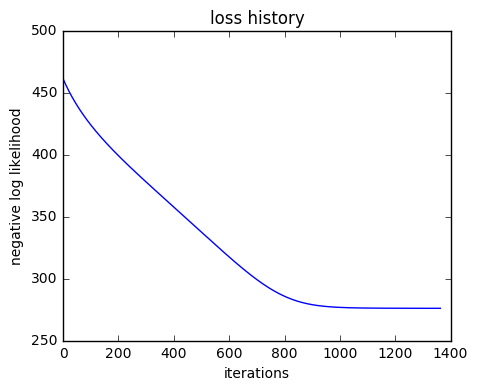

In [7]:
plt.plot(AR_solver.loss_history)
plt.xlabel('iterations')
plt.ylabel('negative log likelihood')
plt.title('loss history')
plt.show()

In [8]:
# initialize the model
lag = 1
sigma = 2.0
intercept = 0.1
phi = np.random.randn(lag, 1)
AR_model = AR(lag=lag, phi=phi, sigma=sigma, intercept=intercept)

AR_solver_momentum = Solver(AR_model, Y,
                          update_rule='sgd_momentum',
                          optim_config={
                            'learning_rate': 1e-5,
                          },
                          
                          num_epochs=3000, batch_size=1,
                          print_every=100)
AR_solver_momentum.train()
AR_model.params

3000
the loss is 338.397396
the loss is 283.758702
the loss is 276.028934


{'intercept': array([-0.1088345]),
 'phi': array([[ 0.48059995]]),
 'sigma': array([ 0.96831281])}

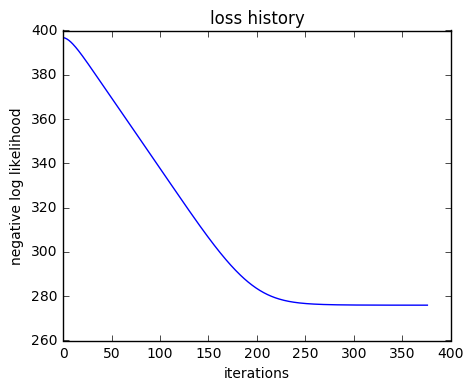

In [9]:
plt.plot(AR_solver_momentum.loss_history)
plt.xlabel('iterations')
plt.ylabel('negative log likelihood')
plt.title('loss history')
plt.show()

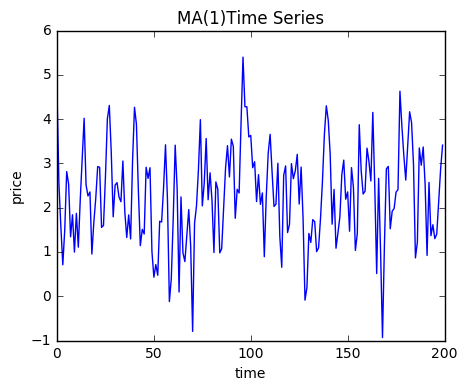

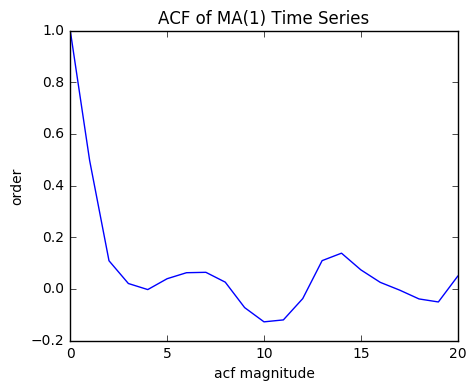

In [10]:
# generate a fake time series and plot it
from tsap.ts_gen import ma1_gen
Y = ma1_gen(0.5, constant = 2.0, time = 200, num = 1, burnin = 2000)
plt.plot(Y.T)
plt.xlabel('time')
plt.ylabel('price')
plt.title('MA(1)Time Series')
plt.show()

# add acf
acf_array = inference.acf(Y, nlags = 20)
plt.plot(acf_array)
plt.xlabel('acf magnitude')
plt.ylabel('order')
plt.title('ACF of MA(1) Time Series')
plt.show()


In [12]:
# initialize the model
lag = 1
sigma = 1.1
intercept = 2.0
phi = np.random.randn(lag, 1)
MA_model = MA(lag=lag, phi=phi, sigma=sigma, intercept=intercept)

# check whether the gradients are properly calculated
_, grads = MA_model.loss(Y)
print grads
MA_solver = Solver(MA_model, Y,
                          update_rule='sgd',
                          optim_config={
                            'learning_rate': 3e-5,
                          },
                          
                          num_epochs=3000, batch_size=1,
                          print_every=100)
MA_solver.train()
MA_model.params

{'phi': array([[ 271.02275212]]), 'intercept': array(0.0), 'sigma': array(-499.2348652024247)}
3000
the loss is 382.017267
the loss is 379.290737


{'intercept': 2.0, 'phi': array([[-0.80540562]]), 'sigma': 1.2681417889908233}

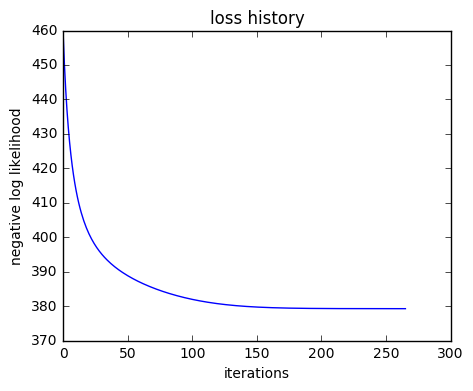

In [13]:
plt.plot(MA_solver.loss_history)
plt.xlabel('iterations')
plt.ylabel('negative log likelihood')
plt.title('loss history')
plt.show()

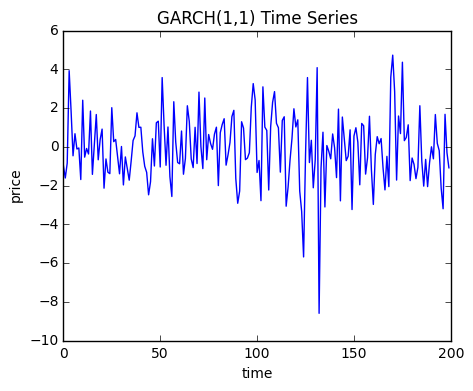

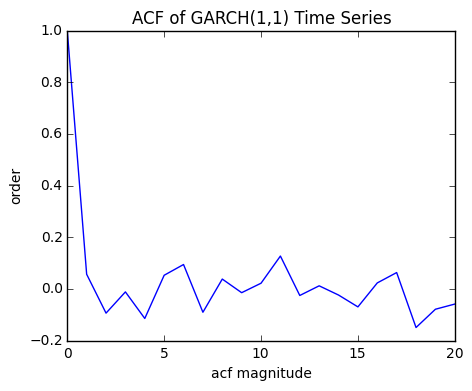

In [26]:
# generate a fake time series and plot it
from tsap.ts_gen import garch11_gen
Y = garch11_gen(a = 1.4, b = 0.6, c = 0.1, time = 200, num = 1, burnin = 2000)
plt.plot(Y.T)
plt.xlabel('time')
plt.ylabel('price')
plt.title('GARCH(1,1) Time Series')
plt.show()


acf_array = inference.acf(Y, nlags = 20)
plt.plot(acf_array)
plt.xlabel('acf magnitude')
plt.ylabel('order')
plt.title('ACF of GARCH(1,1) Time Series')
plt.show()

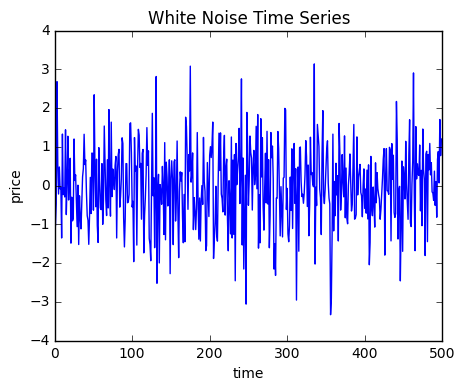

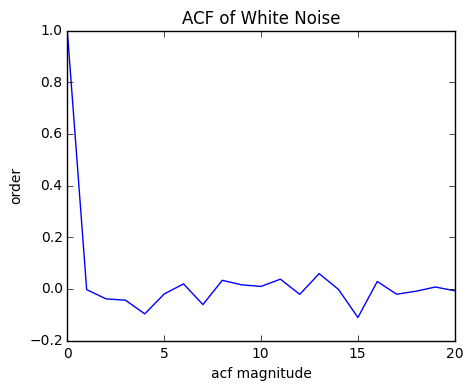

In [20]:
from tsap.ts_gen import ar1_gen
Y = ar1_gen(0, sigma = 1.0, time = 500, num = 1, burnin = 2000)
plt.plot(Y.T)
plt.xlabel('time')
plt.ylabel('price')
plt.title('White Noise Time Series')
plt.show()


acf_array = inference.acf(Y, nlags = 20)
plt.plot(acf_array)
plt.xlabel('acf magnitude')
plt.ylabel('order')
plt.title('ACF of White Noise ')
plt.show()